In [1]:
import keras
import scipy
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer

plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=15)    # legend fontsize

In [2]:
def make_train_test(data, test_size=0.3):
    sbd = data[data['sbj'] == 0]
    X_train, X_test, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
    for i in range(1, data.sbj.max()+1):
        sbd = data[data['sbj'] == i]
        tr, ts, y1, y2 = train_test_split(sbd, sbd, test_size=test_size, random_state=1111)
        X_train = pd.concat([X_train, tr])
        X_test = pd.concat([X_test, ts])
        
    return X_train.reset_index(drop=True), X_test.reset_index(drop=True)

In [3]:
def Race(v, b, ndt=0, dt=0.001):
    x = np.array([0.0, 0.0])
    rt = 0
    ch = -1
    stop = False
    while not stop:
        x[0] += v[0]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        x[1] += v[1]*dt + np.random.normal(0, 1)*np.sqrt(dt)
        rt += dt
        if x[0]>= b and x[1]<b:
            ch = 0.0
            stop = True
        elif x[1]>= b and x[0]<b:
            ch = 1.0
            stop = True
        elif x[0]>= b and x[1]>=b:
            rt = 0
            x = np.array([0.0, 0.0])
    return rt+ndt, ch

In [4]:
df1 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_Less_NoBin.csv', index_col=0)
df2 = pd.read_csv('../../../_data/Sepulveda_et_al_2020-master/data/perceptual/GlamDataPF2019_More_NoBin.csv', index_col=0)
df1['goal'] = -1
df2['goal'] = 1
data_df = pd.concat([df1, df2]).sort_values(by=['subject', 'trial'])
data_df.reset_index(drop=True, inplace=True)

data_df['rt'] /= 1000

data_df.rename(columns={'subject': 'sbj'}, inplace=True)
data_df['sbj'] = data_df['sbj'].map({data_df['sbj'].unique()[i]:i for i in range(len(data_df['sbj'].unique()))})

mean_rt = data_df.groupby('sbj')['rt'].mean()
std_rt = data_df.groupby('sbj')['rt'].std()
RT_Max = mean_rt + 3 * std_rt

rt_max = []
for i in range(data_df.shape[0]):
    rt_max.append(RT_Max[data_df['sbj'][i]])
data_df['rt_max'] = rt_max
data_df = data_df[(data_df['rt']>0.25) & (data_df['rt']<data_df['rt_max'])].reset_index(drop=True)

data_df.reset_index(drop=True, inplace=True)

data_df['value diff'] = data_df['item_value_1'] - data_df['item_value_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['value diff'] = kbins.fit_transform(data_df[['value diff']])
mms = MinMaxScaler(feature_range=(-20, 20))
data_df['Right Value - Left Value'] = mms.fit_transform(data_df[['value diff']])

data_df['gaze diff'] = data_df['gaze_1'] - data_df['gaze_0']
kbins = KBinsDiscretizer(n_bins=9, encode='ordinal', strategy='uniform')
data_df['gaze diff'] = kbins.fit_transform(data_df[['gaze diff']])
mms = MinMaxScaler(feature_range=(-1, 1))
data_df['Dwell Time Advantage (R - L)'] = mms.fit_transform(data_df[['gaze diff']])

min_rt = data_df.groupby(by='sbj')['rt'].min()

In [5]:
tr_df, ts_df = make_train_test(data_df, test_size=0.4)

obs_train = np.asarray(tr_df[['rt', 'choice', 'sbj']])
X_train = np.asarray(tr_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

obs_test = np.asarray(ts_df[['rt', 'choice', 'sbj']])
X_test = np.asarray(ts_df[['item_value_0', 'item_value_1', 'gaze_0', 'gaze_1', 'goal']])

print(X_train.shape, X_test.shape)

(4521, 5) (3034, 5)


In [6]:
def fpt(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(b/(2*np.pi*t**3)**(1/2) * keras.backend.exp(-1/(2*t) * (v*t-b)**2)) + tf.cast(tf.math.less_equal(t, 0), tf.float32)*0.1**10

def phi(x):
    return 0.5*tf.math.erf(x/tf.sqrt(2.0)) + 0.5

def cdf(t, b, v):
    return tf.cast(tf.math.greater(t, 0), tf.float32)*(phi((v*t-b)/tf.sqrt(t)) + tf.exp(2*v*b)*phi((-v*t-b)/tf.sqrt(t))) + (tf.cast(tf.math.less_equal(t, 0), tf.float32)*0)

def G2(data, pred):

    sbj_indices = tf.cast(data[:, 2], tf.int32)

    # Gather values directly using TensorFlow operations
    gathered_min_rt = tf.gather(min_rt, sbj_indices)
    sigmoid_weights = tf.gather(model.layers[-1].weights[-1], sbj_indices)
    ndt = gathered_min_rt * tf.math.sigmoid(sigmoid_weights)

    thr_weights = tf.gather(model.layers[-1].weights[-2], sbj_indices)
    thr = tf.math.log(1 + tf.exp(thr_weights))

    scl_weights = tf.gather(model.layers[-1].weights[-3], sbj_indices)
    scl = tf.math.log(1 + tf.exp(scl_weights))

    ll1 = (1 - data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 0]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 1]))
    ll2 = (data[:, 1]) * fpt(data[:, 0]-ndt, thr, scl*pred[:, 1]) * (1.0 - cdf(data[:, 0]-ndt, thr, scl*pred[:, 0]))

    return -2*tf.reduce_sum(tf.math.log(ll1 + ll2 + 0.1**14), axis=-1)

In [7]:
class Out_layer(keras.layers.Layer):
    def __init__(self, units=2, input_dim=32, n_sbj_prms=10):
        super().__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(units,), initializer="uniform", trainable=True)
        
        self.scaling = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.threshold = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)
        self.non_decision_time = self.add_weight(shape=(n_sbj_prms,), initializer="uniform", trainable=True)

    def call(self, inputs):
        return tf.math.log(1 + tf.exp(tf.matmul(inputs, self.w) + self.b))
    
def make_model(layers_neuron, input_shape, output_shape, activation, n_sbj_prms):
    keras.backend.clear_session()

    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    
    for l in layers_neuron:
        model.add(layers.Dense(l, activation=activation))
    
    model.add(Out_layer(units=output_shape, input_dim=layers_neuron[-1], n_sbj_prms=n_sbj_prms))

    print(model.summary())
    
    return model

In [8]:
layers_neuron = [10, 10, 10, 8]
input_shape = 5
output_shape = 2
activation = 'tanh'
n_sbj = tr_df.sbj.nunique()

model = make_model(layers_neuron, input_shape, output_shape, activation, n_sbj)

model.build()
model.compile(optimizer="RMSprop", loss=G2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                60        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 8)                 88        
                                                                 
 out_layer (Out_layer)       (None, 2)                 114       
                                                                 
Total params: 482 (1.88 KB)
Trainable params: 482 (1.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [9]:
sbj_indices = tf.cast(obs_train[:, 2], tf.int32)
obs_train = tf.cast(obs_train, tf.float32)
X_train = tf.convert_to_tensor(X_train)
X_train = tf.cast(X_train, tf.float32)

min_rt = tf.convert_to_tensor(min_rt)
min_rt = tf.cast(min_rt, tf.float32)

In [10]:
history = model.fit(X_train, 
                    obs_train, 
                    shuffle=False, 
                    batch_size=X_train.shape[0], 
                    epochs=3500)

Epoch 1/3500
1/1 [==============================] - 1s 1s/step - loss: 43493.9961
Epoch 2/3500
1/1 [==============================] - 0s 9ms/step - loss: 43157.6562
Epoch 3/3500
1/1 [==============================] - 0s 10ms/step - loss: 42922.6602
Epoch 4/3500
1/1 [==============================] - 0s 7ms/step - loss: 42727.0000
Epoch 5/3500
1/1 [==============================] - 0s 9ms/step - loss: 42553.5938
Epoch 6/3500
1/1 [==============================] - 0s 10ms/step - loss: 42395.0430
Epoch 7/3500
1/1 [==============================] - 0s 7ms/step - loss: 42247.3398
Epoch 8/3500
1/1 [==============================] - 0s 12ms/step - loss: 42108.0547
Epoch 9/3500
1/1 [==============================] - 0s 7ms/step - loss: 41975.5938
Epoch 10/3500
1/1 [==============================] - 0s 8ms/step - loss: 41848.8359
Epoch 11/3500
1/1 [==============================] - 0s 10ms/step - loss: 41726.9453
Epoch 12/3500
1/1 [==============================] - 0s 9ms/step - loss: 41609.308

1/1 [==============================] - 0s 8ms/step - loss: 35643.9453
Epoch 99/3500
1/1 [==============================] - 0s 8ms/step - loss: 35599.2500
Epoch 100/3500
1/1 [==============================] - 0s 8ms/step - loss: 35554.9531
Epoch 101/3500
1/1 [==============================] - 0s 9ms/step - loss: 35511.0469
Epoch 102/3500
1/1 [==============================] - 0s 10ms/step - loss: 35467.5391
Epoch 103/3500
1/1 [==============================] - 0s 10ms/step - loss: 35424.4141
Epoch 104/3500
1/1 [==============================] - 0s 8ms/step - loss: 35381.6797
Epoch 105/3500
1/1 [==============================] - 0s 11ms/step - loss: 35339.3203
Epoch 106/3500
1/1 [==============================] - 0s 11ms/step - loss: 35297.3359
Epoch 107/3500
1/1 [==============================] - 0s 10ms/step - loss: 35255.7422
Epoch 108/3500
1/1 [==============================] - 0s 8ms/step - loss: 35214.5156
Epoch 109/3500
1/1 [==============================] - 0s 9ms/step - loss: 35

1/1 [==============================] - 0s 8ms/step - loss: 32686.2832
Epoch 195/3500
1/1 [==============================] - 0s 10ms/step - loss: 32665.0566
Epoch 196/3500
1/1 [==============================] - 0s 10ms/step - loss: 32643.9531
Epoch 197/3500
1/1 [==============================] - 0s 10ms/step - loss: 32622.9746
Epoch 198/3500
1/1 [==============================] - 0s 9ms/step - loss: 32602.1152
Epoch 199/3500
1/1 [==============================] - 0s 10ms/step - loss: 32581.3750
Epoch 200/3500
1/1 [==============================] - 0s 10ms/step - loss: 32560.7500
Epoch 201/3500
1/1 [==============================] - 0s 9ms/step - loss: 32540.2441
Epoch 202/3500
1/1 [==============================] - 0s 10ms/step - loss: 32519.8535
Epoch 203/3500
1/1 [==============================] - 0s 10ms/step - loss: 32499.5742
Epoch 204/3500
1/1 [==============================] - 0s 9ms/step - loss: 32479.4023
Epoch 205/3500
1/1 [==============================] - 0s 10ms/step - loss

1/1 [==============================] - 0s 10ms/step - loss: 31046.8438
Epoch 291/3500
1/1 [==============================] - 0s 11ms/step - loss: 31032.6992
Epoch 292/3500
1/1 [==============================] - 0s 9ms/step - loss: 31018.5918
Epoch 293/3500
1/1 [==============================] - 0s 9ms/step - loss: 31004.5312
Epoch 294/3500
1/1 [==============================] - 0s 9ms/step - loss: 30990.5098
Epoch 295/3500
1/1 [==============================] - 0s 8ms/step - loss: 30976.5273
Epoch 296/3500
1/1 [==============================] - 0s 10ms/step - loss: 30962.5879
Epoch 297/3500
1/1 [==============================] - 0s 8ms/step - loss: 30948.6777
Epoch 298/3500
1/1 [==============================] - 0s 10ms/step - loss: 30934.8164
Epoch 299/3500
1/1 [==============================] - 0s 10ms/step - loss: 30920.9883
Epoch 300/3500
1/1 [==============================] - 0s 8ms/step - loss: 30907.2012
Epoch 301/3500
1/1 [==============================] - 0s 8ms/step - loss: 3

1/1 [==============================] - 0s 9ms/step - loss: 29832.9863
Epoch 387/3500
1/1 [==============================] - 0s 9ms/step - loss: 29821.5234
Epoch 388/3500
1/1 [==============================] - 0s 8ms/step - loss: 29810.0801
Epoch 389/3500
1/1 [==============================] - 0s 10ms/step - loss: 29798.6543
Epoch 390/3500
1/1 [==============================] - 0s 10ms/step - loss: 29787.2500
Epoch 391/3500
1/1 [==============================] - 0s 9ms/step - loss: 29775.8652
Epoch 392/3500
1/1 [==============================] - 0s 10ms/step - loss: 29764.4941
Epoch 393/3500
1/1 [==============================] - 0s 11ms/step - loss: 29753.1484
Epoch 394/3500
1/1 [==============================] - 0s 12ms/step - loss: 29741.8164
Epoch 395/3500
1/1 [==============================] - 0s 11ms/step - loss: 29730.5059
Epoch 396/3500
1/1 [==============================] - 0s 10ms/step - loss: 29719.2129
Epoch 397/3500
1/1 [==============================] - 0s 9ms/step - loss:

1/1 [==============================] - 0s 10ms/step - loss: 28806.9785
Epoch 483/3500
1/1 [==============================] - 0s 8ms/step - loss: 28796.9785
Epoch 484/3500
1/1 [==============================] - 0s 10ms/step - loss: 28786.9922
Epoch 485/3500
1/1 [==============================] - 0s 9ms/step - loss: 28777.0215
Epoch 486/3500
1/1 [==============================] - 0s 9ms/step - loss: 28767.0586
Epoch 487/3500
1/1 [==============================] - 0s 9ms/step - loss: 28757.1133
Epoch 488/3500
1/1 [==============================] - 0s 10ms/step - loss: 28747.1777
Epoch 489/3500
1/1 [==============================] - 0s 9ms/step - loss: 28737.2539
Epoch 490/3500
1/1 [==============================] - 0s 9ms/step - loss: 28727.3457
Epoch 491/3500
1/1 [==============================] - 0s 8ms/step - loss: 28717.4512
Epoch 492/3500
1/1 [==============================] - 0s 9ms/step - loss: 28707.5645
Epoch 493/3500
1/1 [==============================] - 0s 9ms/step - loss: 286

1/1 [==============================] - 0s 9ms/step - loss: 27901.6719
Epoch 579/3500
1/1 [==============================] - 0s 11ms/step - loss: 27892.7969
Epoch 580/3500
1/1 [==============================] - 0s 8ms/step - loss: 27883.9277
Epoch 581/3500
1/1 [==============================] - 0s 9ms/step - loss: 27875.0742
Epoch 582/3500
1/1 [==============================] - 0s 7ms/step - loss: 27866.2266
Epoch 583/3500
1/1 [==============================] - 0s 8ms/step - loss: 27857.3965
Epoch 584/3500
1/1 [==============================] - 0s 8ms/step - loss: 27848.5742
Epoch 585/3500
1/1 [==============================] - 0s 7ms/step - loss: 27839.7637
Epoch 586/3500
1/1 [==============================] - 0s 8ms/step - loss: 27830.9648
Epoch 587/3500
1/1 [==============================] - 0s 8ms/step - loss: 27822.1758
Epoch 588/3500
1/1 [==============================] - 0s 8ms/step - loss: 27813.3984
Epoch 589/3500
1/1 [==============================] - 0s 7ms/step - loss: 27804

1/1 [==============================] - 0s 6ms/step - loss: 27095.0820
Epoch 675/3500
1/1 [==============================] - 0s 9ms/step - loss: 27087.1191
Epoch 676/3500
1/1 [==============================] - 0s 8ms/step - loss: 27079.1641
Epoch 677/3500
1/1 [==============================] - 0s 7ms/step - loss: 27071.2188
Epoch 678/3500
1/1 [==============================] - 0s 7ms/step - loss: 27063.2812
Epoch 679/3500
1/1 [==============================] - 0s 11ms/step - loss: 27055.3516
Epoch 680/3500
1/1 [==============================] - 0s 11ms/step - loss: 27047.4297
Epoch 681/3500
1/1 [==============================] - 0s 8ms/step - loss: 27039.5156
Epoch 682/3500
1/1 [==============================] - 0s 12ms/step - loss: 27031.6094
Epoch 683/3500
1/1 [==============================] - 0s 12ms/step - loss: 27023.7109
Epoch 684/3500
1/1 [==============================] - 0s 10ms/step - loss: 27015.8203
Epoch 685/3500
1/1 [==============================] - 0s 10ms/step - loss: 

1/1 [==============================] - 0s 7ms/step - loss: 26361.9883
Epoch 771/3500
1/1 [==============================] - 0s 8ms/step - loss: 26353.7793
Epoch 772/3500
1/1 [==============================] - 0s 8ms/step - loss: 26345.3203
Epoch 773/3500
1/1 [==============================] - 0s 8ms/step - loss: 26336.5312
Epoch 774/3500
1/1 [==============================] - 0s 7ms/step - loss: 26327.3164
Epoch 775/3500
1/1 [==============================] - 0s 8ms/step - loss: 26317.4922
Epoch 776/3500
1/1 [==============================] - 0s 7ms/step - loss: 26306.9141
Epoch 777/3500
1/1 [==============================] - 0s 7ms/step - loss: 26295.6211
Epoch 778/3500
1/1 [==============================] - 0s 7ms/step - loss: 26283.7344
Epoch 779/3500
1/1 [==============================] - 0s 7ms/step - loss: 26271.7031
Epoch 780/3500
1/1 [==============================] - 0s 7ms/step - loss: 26260.5938
Epoch 781/3500
1/1 [==============================] - 0s 7ms/step - loss: 26251.

1/1 [==============================] - 0s 9ms/step - loss: 25440.6270
Epoch 867/3500
1/1 [==============================] - 0s 8ms/step - loss: 25429.6875
Epoch 868/3500
1/1 [==============================] - 0s 8ms/step - loss: 25421.7031
Epoch 869/3500
1/1 [==============================] - 0s 8ms/step - loss: 25410.9746
Epoch 870/3500
1/1 [==============================] - 0s 8ms/step - loss: 25402.9668
Epoch 871/3500
1/1 [==============================] - 0s 8ms/step - loss: 25392.4238
Epoch 872/3500
1/1 [==============================] - 0s 7ms/step - loss: 25384.3555
Epoch 873/3500
1/1 [==============================] - 0s 8ms/step - loss: 25373.9570
Epoch 874/3500
1/1 [==============================] - 0s 8ms/step - loss: 25365.7930
Epoch 875/3500
1/1 [==============================] - 0s 9ms/step - loss: 25355.5312
Epoch 876/3500
1/1 [==============================] - 0s 8ms/step - loss: 25347.2617
Epoch 877/3500
1/1 [==============================] - 0s 8ms/step - loss: 25337.

1/1 [==============================] - 0s 9ms/step - loss: 24646.5371
Epoch 963/3500
1/1 [==============================] - 0s 11ms/step - loss: 24644.3574
Epoch 964/3500
1/1 [==============================] - 0s 12ms/step - loss: 24632.1660
Epoch 965/3500
1/1 [==============================] - 0s 9ms/step - loss: 24630.0273
Epoch 966/3500
1/1 [==============================] - 0s 9ms/step - loss: 24617.8789
Epoch 967/3500
1/1 [==============================] - 0s 16ms/step - loss: 24615.7656
Epoch 968/3500
1/1 [==============================] - 0s 16ms/step - loss: 24603.6719
Epoch 969/3500
1/1 [==============================] - 0s 12ms/step - loss: 24601.5664
Epoch 970/3500
1/1 [==============================] - 0s 9ms/step - loss: 24589.5430
Epoch 971/3500
1/1 [==============================] - 0s 11ms/step - loss: 24587.4375
Epoch 972/3500
1/1 [==============================] - 0s 13ms/step - loss: 24575.4961
Epoch 973/3500
1/1 [==============================] - 0s 14ms/step - loss

Epoch 1057/3500
1/1 [==============================] - 0s 13ms/step - loss: 24037.7734
Epoch 1058/3500
1/1 [==============================] - 0s 13ms/step - loss: 24027.0000
Epoch 1059/3500
1/1 [==============================] - 0s 12ms/step - loss: 24025.9258
Epoch 1060/3500
1/1 [==============================] - 0s 14ms/step - loss: 24015.1367
Epoch 1061/3500
1/1 [==============================] - 0s 13ms/step - loss: 24014.1074
Epoch 1062/3500
1/1 [==============================] - 0s 16ms/step - loss: 24003.3086
Epoch 1063/3500
1/1 [==============================] - 0s 19ms/step - loss: 24002.3203
Epoch 1064/3500
1/1 [==============================] - 0s 16ms/step - loss: 23991.5176
Epoch 1065/3500
1/1 [==============================] - 0s 19ms/step - loss: 23990.5605
Epoch 1066/3500
1/1 [==============================] - 0s 15ms/step - loss: 23979.7578
Epoch 1067/3500
1/1 [==============================] - 0s 19ms/step - loss: 23978.8281
Epoch 1068/3500
1/1 [======================

1/1 [==============================] - 0s 9ms/step - loss: 23503.4141
Epoch 1152/3500
1/1 [==============================] - 0s 8ms/step - loss: 23495.0742
Epoch 1153/3500
1/1 [==============================] - 0s 9ms/step - loss: 23492.2617
Epoch 1154/3500
1/1 [==============================] - 0s 8ms/step - loss: 23484.0352
Epoch 1155/3500
1/1 [==============================] - 0s 8ms/step - loss: 23481.1055
Epoch 1156/3500
1/1 [==============================] - 0s 9ms/step - loss: 23472.9922
Epoch 1157/3500
1/1 [==============================] - 0s 8ms/step - loss: 23469.9375
Epoch 1158/3500
1/1 [==============================] - 0s 9ms/step - loss: 23461.9414
Epoch 1159/3500
1/1 [==============================] - 0s 9ms/step - loss: 23458.7578
Epoch 1160/3500
1/1 [==============================] - 0s 9ms/step - loss: 23450.8770
Epoch 1161/3500
1/1 [==============================] - 0s 8ms/step - loss: 23447.5625
Epoch 1162/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 22943.2461
Epoch 1246/3500
1/1 [==============================] - 0s 8ms/step - loss: 22941.4414
Epoch 1247/3500
1/1 [==============================] - 0s 8ms/step - loss: 22929.8164
Epoch 1248/3500
1/1 [==============================] - 0s 8ms/step - loss: 22928.0605
Epoch 1249/3500
1/1 [==============================] - 0s 8ms/step - loss: 22916.2930
Epoch 1250/3500
1/1 [==============================] - 0s 9ms/step - loss: 22914.5977
Epoch 1251/3500
1/1 [==============================] - 0s 8ms/step - loss: 22902.6914
Epoch 1252/3500
1/1 [==============================] - 0s 8ms/step - loss: 22901.0508
Epoch 1253/3500
1/1 [==============================] - 0s 9ms/step - loss: 22888.9902
Epoch 1254/3500
1/1 [==============================] - 0s 10ms/step - loss: 22887.3867
Epoch 1255/3500
1/1 [==============================] - 0s 8ms/step - loss: 22875.1641
Epoch 1256/3500
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 22176.7070
Epoch 1341/3500
1/1 [==============================] - 0s 8ms/step - loss: 22161.2109
Epoch 1342/3500
1/1 [==============================] - 0s 8ms/step - loss: 22159.2793
Epoch 1343/3500
1/1 [==============================] - 0s 8ms/step - loss: 22143.9023
Epoch 1344/3500
1/1 [==============================] - 0s 8ms/step - loss: 22142.0742
Epoch 1345/3500
1/1 [==============================] - 0s 8ms/step - loss: 22126.8184
Epoch 1346/3500
1/1 [==============================] - 0s 8ms/step - loss: 22125.0938
Epoch 1347/3500
1/1 [==============================] - 0s 8ms/step - loss: 22109.9688
Epoch 1348/3500
1/1 [==============================] - 0s 8ms/step - loss: 22108.3477
Epoch 1349/3500
1/1 [==============================] - 0s 8ms/step - loss: 22093.3594
Epoch 1350/3500
1/1 [==============================] - 0s 8ms/step - loss: 22091.8438
Epoch 1351/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 9ms/step - loss: 21511.8281
Epoch 1436/3500
1/1 [==============================] - 0s 10ms/step - loss: 21500.0000
Epoch 1437/3500
1/1 [==============================] - 0s 8ms/step - loss: 21500.9902
Epoch 1438/3500
1/1 [==============================] - 0s 8ms/step - loss: 21488.7305
Epoch 1439/3500
1/1 [==============================] - 0s 8ms/step - loss: 21490.3398
Epoch 1440/3500
1/1 [==============================] - 0s 8ms/step - loss: 21477.6719
Epoch 1441/3500
1/1 [==============================] - 0s 8ms/step - loss: 21479.8809
Epoch 1442/3500
1/1 [==============================] - 0s 9ms/step - loss: 21466.8320
Epoch 1443/3500
1/1 [==============================] - 0s 8ms/step - loss: 21469.6230
Epoch 1444/3500
1/1 [==============================] - 0s 9ms/step - loss: 21456.2031
Epoch 1445/3500
1/1 [==============================] - 0s 9ms/step - loss: 21459.5605
Epoch 1446/3500
1/1 [==============================] - 0s 9ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 21111.5781
Epoch 1531/3500
1/1 [==============================] - 0s 7ms/step - loss: 21125.5938
Epoch 1532/3500
1/1 [==============================] - 0s 7ms/step - loss: 21104.7188
Epoch 1533/3500
1/1 [==============================] - 0s 7ms/step - loss: 21118.7871
Epoch 1534/3500
1/1 [==============================] - 0s 8ms/step - loss: 21097.9023
Epoch 1535/3500
1/1 [==============================] - 0s 7ms/step - loss: 21111.9961
Epoch 1536/3500
1/1 [==============================] - 0s 7ms/step - loss: 21091.1172
Epoch 1537/3500
1/1 [==============================] - 0s 7ms/step - loss: 21105.2383
Epoch 1538/3500
1/1 [==============================] - 0s 7ms/step - loss: 21084.3398
Epoch 1539/3500
1/1 [==============================] - 0s 7ms/step - loss: 21098.4707
Epoch 1540/3500
1/1 [==============================] - 0s 7ms/step - loss: 21077.6172
Epoch 1541/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 20837.5664
Epoch 1626/3500
1/1 [==============================] - 0s 8ms/step - loss: 20820.3223
Epoch 1627/3500
1/1 [==============================] - 0s 8ms/step - loss: 20832.0312
Epoch 1628/3500
1/1 [==============================] - 0s 7ms/step - loss: 20814.9531
Epoch 1629/3500
1/1 [==============================] - 0s 7ms/step - loss: 20826.6035
Epoch 1630/3500
1/1 [==============================] - 0s 7ms/step - loss: 20809.6133
Epoch 1631/3500
1/1 [==============================] - 0s 7ms/step - loss: 20821.1328
Epoch 1632/3500
1/1 [==============================] - 0s 7ms/step - loss: 20804.2578
Epoch 1633/3500
1/1 [==============================] - 0s 8ms/step - loss: 20815.6504
Epoch 1634/3500
1/1 [==============================] - 0s 8ms/step - loss: 20798.9727
Epoch 1635/3500
1/1 [==============================] - 0s 8ms/step - loss: 20810.2812
Epoch 1636/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 20592.0293
Epoch 1721/3500
1/1 [==============================] - 0s 8ms/step - loss: 20601.3438
Epoch 1722/3500
1/1 [==============================] - 0s 8ms/step - loss: 20587.5000
Epoch 1723/3500
1/1 [==============================] - 0s 8ms/step - loss: 20596.3301
Epoch 1724/3500
1/1 [==============================] - 0s 7ms/step - loss: 20582.5859
Epoch 1725/3500
1/1 [==============================] - 0s 7ms/step - loss: 20591.4180
Epoch 1726/3500
1/1 [==============================] - 0s 8ms/step - loss: 20578.1406
Epoch 1727/3500
1/1 [==============================] - 0s 8ms/step - loss: 20587.2227
Epoch 1728/3500
1/1 [==============================] - 0s 8ms/step - loss: 20574.4492
Epoch 1729/3500
1/1 [==============================] - 0s 9ms/step - loss: 20583.8477
Epoch 1730/3500
1/1 [==============================] - 0s 8ms/step - loss: 20570.7969
Epoch 1731/3500
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 20413.6992
Epoch 1816/3500
1/1 [==============================] - 0s 8ms/step - loss: 20404.0254
Epoch 1817/3500
1/1 [==============================] - 0s 8ms/step - loss: 20410.7656
Epoch 1818/3500
1/1 [==============================] - 0s 8ms/step - loss: 20401.7871
Epoch 1819/3500
1/1 [==============================] - 0s 7ms/step - loss: 20408.7500
Epoch 1820/3500
1/1 [==============================] - 0s 7ms/step - loss: 20399.0273
Epoch 1821/3500
1/1 [==============================] - 0s 7ms/step - loss: 20405.1562
Epoch 1822/3500
1/1 [==============================] - 0s 7ms/step - loss: 20394.5195
Epoch 1823/3500
1/1 [==============================] - 0s 8ms/step - loss: 20399.8340
Epoch 1824/3500
1/1 [==============================] - 0s 8ms/step - loss: 20390.0664
Epoch 1825/3500
1/1 [==============================] - 0s 7ms/step - loss: 20396.1680
Epoch 1826/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 20246.2578
Epoch 1911/3500
1/1 [==============================] - 0s 8ms/step - loss: 20248.1562
Epoch 1912/3500
1/1 [==============================] - 0s 8ms/step - loss: 20240.3125
Epoch 1913/3500
1/1 [==============================] - 0s 8ms/step - loss: 20243.6250
Epoch 1914/3500
1/1 [==============================] - 0s 8ms/step - loss: 20237.5977
Epoch 1915/3500
1/1 [==============================] - 0s 8ms/step - loss: 20242.4180
Epoch 1916/3500
1/1 [==============================] - 0s 8ms/step - loss: 20236.9316
Epoch 1917/3500
1/1 [==============================] - 0s 8ms/step - loss: 20241.6074
Epoch 1918/3500
1/1 [==============================] - 0s 8ms/step - loss: 20234.8066
Epoch 1919/3500
1/1 [==============================] - 0s 8ms/step - loss: 20237.9961
Epoch 1920/3500
1/1 [==============================] - 0s 8ms/step - loss: 20230.0664
Epoch 1921/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 10ms/step - loss: 20121.4883
Epoch 2006/3500
1/1 [==============================] - 0s 10ms/step - loss: 20104.0195
Epoch 2007/3500
1/1 [==============================] - 0s 10ms/step - loss: 20093.6035
Epoch 2008/3500
1/1 [==============================] - 0s 10ms/step - loss: 20087.3516
Epoch 2009/3500
1/1 [==============================] - 0s 10ms/step - loss: 20092.3047
Epoch 2010/3500
1/1 [==============================] - 0s 9ms/step - loss: 20094.7852
Epoch 2011/3500
1/1 [==============================] - 0s 7ms/step - loss: 20102.9355
Epoch 2012/3500
1/1 [==============================] - 0s 6ms/step - loss: 20109.2305
Epoch 2013/3500
1/1 [==============================] - 0s 6ms/step - loss: 20115.9219
Epoch 2014/3500
1/1 [==============================] - 0s 7ms/step - loss: 20114.4375
Epoch 2015/3500
1/1 [==============================] - 0s 7ms/step - loss: 20110.9043
Epoch 2016/3500
1/1 [==============================] - 0s 7ms/ste

1/1 [==============================] - 0s 9ms/step - loss: 20019.2188
Epoch 2101/3500
1/1 [==============================] - 0s 9ms/step - loss: 20040.1836
Epoch 2102/3500
1/1 [==============================] - 0s 7ms/step - loss: 20029.1895
Epoch 2103/3500
1/1 [==============================] - 0s 8ms/step - loss: 20005.4121
Epoch 2104/3500
1/1 [==============================] - 0s 8ms/step - loss: 19983.8203
Epoch 2105/3500
1/1 [==============================] - 0s 8ms/step - loss: 19962.4219
Epoch 2106/3500
1/1 [==============================] - 0s 9ms/step - loss: 19958.0586
Epoch 2107/3500
1/1 [==============================] - 0s 11ms/step - loss: 19958.1973
Epoch 2108/3500
1/1 [==============================] - 0s 9ms/step - loss: 19970.4453
Epoch 2109/3500
1/1 [==============================] - 0s 8ms/step - loss: 19984.2031
Epoch 2110/3500
1/1 [==============================] - 0s 9ms/step - loss: 20005.8672
Epoch 2111/3500
1/1 [==============================] - 0s 10ms/step -

1/1 [==============================] - 0s 8ms/step - loss: 19802.7090
Epoch 2196/3500
1/1 [==============================] - 0s 8ms/step - loss: 19788.0312
Epoch 2197/3500
1/1 [==============================] - 0s 8ms/step - loss: 19782.4883
Epoch 2198/3500
1/1 [==============================] - 0s 8ms/step - loss: 19782.6016
Epoch 2199/3500
1/1 [==============================] - 0s 8ms/step - loss: 19790.4805
Epoch 2200/3500
1/1 [==============================] - 0s 8ms/step - loss: 19811.1992
Epoch 2201/3500
1/1 [==============================] - 0s 8ms/step - loss: 19864.6914
Epoch 2202/3500
1/1 [==============================] - 0s 7ms/step - loss: 19960.4648
Epoch 2203/3500
1/1 [==============================] - 0s 13ms/step - loss: 20092.0020
Epoch 2204/3500
1/1 [==============================] - 0s 11ms/step - loss: 20096.8379
Epoch 2205/3500
1/1 [==============================] - 0s 9ms/step - loss: 20007.6152
Epoch 2206/3500
1/1 [==============================] - 0s 10ms/step 

Epoch 2291/3500
1/1 [==============================] - 0s 9ms/step - loss: 19693.9258
Epoch 2292/3500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoch 2293/3500
1/1 [==============================] - 0s 9ms/step - loss: 19675.9297
Epoch 2294/3500
1/1 [==============================] - 0s 8ms/step - loss: 19673.8809
Epoch 2295/3500
1/1 [==============================] - 0s 9ms/step - loss: 19677.3047
Epoch 2296/3500
1/1 [==============================] - 0s 8ms/step - loss: 19696.0137
Epoch 2297/3500
1/1 [==============================] - 0s 10ms/step - loss: 19793.5234
Epoch 2298/3500
1/1 [==============================] - 0s 12ms/step - loss: 20089.8086
Epoch 2299/3500
1/1 [==============================] - 0s 9ms/step - loss: 20326.6836
Epoch 2300/3500
1/1 [==============================] - 0s 9ms/step - loss: 20125.7344
Epoch 2301/3500
1/1 [==============================] - 0s 8ms/step - loss: 19821.5078
Epoch 2302/3500
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 7ms/step - loss: 19703.6641
Epoch 2387/3500
1/1 [==============================] - 0s 8ms/step - loss: 19690.0293
Epoch 2388/3500
1/1 [==============================] - 0s 9ms/step - loss: 19699.4766
Epoch 2389/3500
1/1 [==============================] - 0s 7ms/step - loss: 19708.2617
Epoch 2390/3500
1/1 [==============================] - 0s 10ms/step - loss: 19741.5625
Epoch 2391/3500
1/1 [==============================] - 0s 7ms/step - loss: 19761.4453
Epoch 2392/3500
1/1 [==============================] - 0s 8ms/step - loss: 19793.9922
Epoch 2393/3500
1/1 [==============================] - 0s 8ms/step - loss: 19779.6680
Epoch 2394/3500
1/1 [==============================] - 0s 8ms/step - loss: 19770.5430
Epoch 2395/3500
1/1 [==============================] - 0s 8ms/step - loss: 19730.4609
Epoch 2396/3500
1/1 [==============================] - 0s 8ms/step - loss: 19715.2559
Epoch 2397/3500
1/1 [==============================] - 0s 8ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 19661.4395
Epoch 2482/3500
1/1 [==============================] - 0s 8ms/step - loss: 19676.4336
Epoch 2483/3500
1/1 [==============================] - 0s 8ms/step - loss: 19664.4062
Epoch 2484/3500
1/1 [==============================] - 0s 8ms/step - loss: 19679.5410
Epoch 2485/3500
1/1 [==============================] - 0s 8ms/step - loss: 19664.9844
Epoch 2486/3500
1/1 [==============================] - 0s 8ms/step - loss: 19677.6133
Epoch 2487/3500
1/1 [==============================] - 0s 9ms/step - loss: 19660.9609
Epoch 2488/3500
1/1 [==============================] - 0s 8ms/step - loss: 19672.0547
Epoch 2489/3500
1/1 [==============================] - 0s 8ms/step - loss: 19656.1211
Epoch 2490/3500
1/1 [==============================] - 0s 8ms/step - loss: 19668.9727
Epoch 2491/3500
1/1 [==============================] - 0s 9ms/step - loss: 19655.3184
Epoch 2492/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 8ms/step - loss: 19614.5586
Epoch 2577/3500
1/1 [==============================] - 0s 8ms/step - loss: 19596.8594
Epoch 2578/3500
1/1 [==============================] - 0s 7ms/step - loss: 19613.2930
Epoch 2579/3500
1/1 [==============================] - 0s 8ms/step - loss: 19595.8496
Epoch 2580/3500
1/1 [==============================] - 0s 7ms/step - loss: 19612.6504
Epoch 2581/3500
1/1 [==============================] - 0s 8ms/step - loss: 19595.0938
Epoch 2582/3500
1/1 [==============================] - 0s 8ms/step - loss: 19610.9922
Epoch 2583/3500
1/1 [==============================] - 0s 8ms/step - loss: 19593.0859
Epoch 2584/3500
1/1 [==============================] - 0s 8ms/step - loss: 19609.3008
Epoch 2585/3500
1/1 [==============================] - 0s 11ms/step - loss: 19591.7461
Epoch 2586/3500
1/1 [==============================] - 0s 10ms/step - loss: 19608.3359
Epoch 2587/3500
1/1 [==============================] - 0s 9ms/step -

1/1 [==============================] - 0s 7ms/step - loss: 19534.3477
Epoch 2672/3500
1/1 [==============================] - 0s 7ms/step - loss: 19549.9023
Epoch 2673/3500
1/1 [==============================] - 0s 7ms/step - loss: 19532.7148
Epoch 2674/3500
1/1 [==============================] - 0s 7ms/step - loss: 19548.0078
Epoch 2675/3500
1/1 [==============================] - 0s 6ms/step - loss: 19530.9648
Epoch 2676/3500
1/1 [==============================] - 0s 7ms/step - loss: 19546.5410
Epoch 2677/3500
1/1 [==============================] - 0s 6ms/step - loss: 19529.8945
Epoch 2678/3500
1/1 [==============================] - 0s 8ms/step - loss: 19545.3008
Epoch 2679/3500
1/1 [==============================] - 0s 9ms/step - loss: 19528.6641
Epoch 2680/3500
1/1 [==============================] - 0s 7ms/step - loss: 19544.3359
Epoch 2681/3500
1/1 [==============================] - 0s 9ms/step - loss: 19527.7441
Epoch 2682/3500
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 11ms/step - loss: 19483.4453
Epoch 2767/3500
1/1 [==============================] - 0s 9ms/step - loss: 19469.6992
Epoch 2768/3500
1/1 [==============================] - 0s 8ms/step - loss: 19482.1250
Epoch 2769/3500
1/1 [==============================] - 0s 7ms/step - loss: 19469.1113
Epoch 2770/3500
1/1 [==============================] - 0s 8ms/step - loss: 19481.4492
Epoch 2771/3500
1/1 [==============================] - 0s 7ms/step - loss: 19468.5273
Epoch 2772/3500
1/1 [==============================] - 0s 8ms/step - loss: 19480.9531
Epoch 2773/3500
1/1 [==============================] - 0s 9ms/step - loss: 19467.5430
Epoch 2774/3500
1/1 [==============================] - 0s 8ms/step - loss: 19479.0352
Epoch 2775/3500
1/1 [==============================] - 0s 9ms/step - loss: 19465.3008
Epoch 2776/3500
1/1 [==============================] - 0s 8ms/step - loss: 19476.7637
Epoch 2777/3500
1/1 [==============================] - 0s 7ms/step - 

1/1 [==============================] - 0s 9ms/step - loss: 19417.5312
Epoch 2862/3500
1/1 [==============================] - 0s 8ms/step - loss: 19424.6602
Epoch 2863/3500
1/1 [==============================] - 0s 8ms/step - loss: 19417.0293
Epoch 2864/3500
1/1 [==============================] - 0s 7ms/step - loss: 19422.2168
Epoch 2865/3500
1/1 [==============================] - 0s 7ms/step - loss: 19413.6328
Epoch 2866/3500
1/1 [==============================] - 0s 8ms/step - loss: 19418.6562
Epoch 2867/3500
1/1 [==============================] - 0s 7ms/step - loss: 19411.3633
Epoch 2868/3500
1/1 [==============================] - 0s 8ms/step - loss: 19417.6660
Epoch 2869/3500
1/1 [==============================] - 0s 7ms/step - loss: 19411.6719
Epoch 2870/3500
1/1 [==============================] - 0s 9ms/step - loss: 19418.5996
Epoch 2871/3500
1/1 [==============================] - 0s 7ms/step - loss: 19412.4883
Epoch 2872/3500
1/1 [==============================] - 0s 8ms/step - l

1/1 [==============================] - 0s 11ms/step - loss: 19370.4551
Epoch 2957/3500
1/1 [==============================] - 0s 8ms/step - loss: 19368.4102
Epoch 2958/3500
1/1 [==============================] - 0s 9ms/step - loss: 19368.9336
Epoch 2959/3500
1/1 [==============================] - 0s 9ms/step - loss: 19367.5469
Epoch 2960/3500
1/1 [==============================] - 0s 10ms/step - loss: 19367.4883
Epoch 2961/3500
1/1 [==============================] - 0s 8ms/step - loss: 19367.4180
Epoch 2962/3500
1/1 [==============================] - 0s 8ms/step - loss: 19366.4961
Epoch 2963/3500
1/1 [==============================] - 0s 8ms/step - loss: 19365.8066
Epoch 2964/3500
1/1 [==============================] - 0s 8ms/step - loss: 19364.5898
Epoch 2965/3500
1/1 [==============================] - 0s 8ms/step - loss: 19364.5293
Epoch 2966/3500
1/1 [==============================] - 0s 8ms/step - loss: 19363.7480
Epoch 2967/3500
1/1 [==============================] - 0s 8ms/step -

1/1 [==============================] - 0s 8ms/step - loss: 19324.2188
Epoch 3052/3500
1/1 [==============================] - 0s 8ms/step - loss: 19319.0059
Epoch 3053/3500
1/1 [==============================] - 0s 8ms/step - loss: 19326.2559
Epoch 3054/3500
1/1 [==============================] - 0s 8ms/step - loss: 19318.8887
Epoch 3055/3500
1/1 [==============================] - 0s 8ms/step - loss: 19325.3574
Epoch 3056/3500
1/1 [==============================] - 0s 7ms/step - loss: 19318.7344
Epoch 3057/3500
1/1 [==============================] - 0s 10ms/step - loss: 19325.3555
Epoch 3058/3500
1/1 [==============================] - 0s 8ms/step - loss: 19315.9609
Epoch 3059/3500
1/1 [==============================] - 0s 8ms/step - loss: 19321.9707
Epoch 3060/3500
1/1 [==============================] - 0s 10ms/step - loss: 19318.5254
Epoch 3061/3500
1/1 [==============================] - 0s 8ms/step - loss: 19324.8594
Epoch 3062/3500
1/1 [==============================] - 0s 8ms/step -

1/1 [==============================] - 0s 24ms/step - loss: 19268.0508
Epoch 3146/3500
1/1 [==============================] - 0s 25ms/step - loss: 19240.7695
Epoch 3147/3500
1/1 [==============================] - 0s 21ms/step - loss: 19246.8633
Epoch 3148/3500
1/1 [==============================] - 0s 28ms/step - loss: 19260.4902
Epoch 3149/3500
1/1 [==============================] - 0s 25ms/step - loss: 19291.8047
Epoch 3150/3500
1/1 [==============================] - 0s 20ms/step - loss: 19293.2754
Epoch 3151/3500
1/1 [==============================] - 0s 18ms/step - loss: 19314.3730
Epoch 3152/3500
1/1 [==============================] - 0s 12ms/step - loss: 19289.1289
Epoch 3153/3500
1/1 [==============================] - 0s 12ms/step - loss: 19290.9629
Epoch 3154/3500
1/1 [==============================] - 0s 12ms/step - loss: 19269.0547
Epoch 3155/3500
1/1 [==============================] - 0s 10ms/step - loss: 19273.1797
Epoch 3156/3500
1/1 [==============================] - 0s 1

Epoch 3240/3500
1/1 [==============================] - 0s 12ms/step - loss: 19254.2969
Epoch 3241/3500
1/1 [==============================] - 0s 12ms/step - loss: 19265.0977
Epoch 3242/3500
1/1 [==============================] - 0s 11ms/step - loss: 19160.0898
Epoch 3243/3500
1/1 [==============================] - 0s 9ms/step - loss: 19174.2012
Epoch 3244/3500
1/1 [==============================] - 0s 9ms/step - loss: 19191.8242
Epoch 3245/3500
1/1 [==============================] - 0s 17ms/step - loss: 19263.0898
Epoch 3246/3500
1/1 [==============================] - 0s 14ms/step - loss: 19326.9961
Epoch 3247/3500
1/1 [==============================] - 0s 14ms/step - loss: 19377.5312
Epoch 3248/3500
1/1 [==============================] - 0s 14ms/step - loss: 19303.6094
Epoch 3249/3500
1/1 [==============================] - 0s 15ms/step - loss: 19267.1484
Epoch 3250/3500
1/1 [==============================] - 0s 14ms/step - loss: 19189.5664
Epoch 3251/3500
1/1 [========================

1/1 [==============================] - 0s 8ms/step - loss: 19230.0918
Epoch 3335/3500
1/1 [==============================] - 0s 9ms/step - loss: 19215.1016
Epoch 3336/3500
1/1 [==============================] - 0s 12ms/step - loss: 19173.5137
Epoch 3337/3500
1/1 [==============================] - 0s 11ms/step - loss: 19177.6035
Epoch 3338/3500
1/1 [==============================] - 0s 11ms/step - loss: 19179.6562
Epoch 3339/3500
1/1 [==============================] - 0s 10ms/step - loss: 19206.8867
Epoch 3340/3500
1/1 [==============================] - 0s 9ms/step - loss: 19221.5762
Epoch 3341/3500
1/1 [==============================] - 0s 12ms/step - loss: nan
Epoch 3342/3500
1/1 [==============================] - 0s 12ms/step - loss: 19340.5117
Epoch 3343/3500
1/1 [==============================] - 0s 9ms/step - loss: 19304.2773
Epoch 3344/3500
1/1 [==============================] - 0s 10ms/step - loss: 19188.6484
Epoch 3345/3500
1/1 [==============================] - 0s 10ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 19115.4102
Epoch 3430/3500
1/1 [==============================] - 0s 9ms/step - loss: 19085.3496
Epoch 3431/3500
1/1 [==============================] - 0s 8ms/step - loss: 19068.5469
Epoch 3432/3500
1/1 [==============================] - 0s 8ms/step - loss: 19082.5312
Epoch 3433/3500
1/1 [==============================] - 0s 8ms/step - loss: 19119.7109
Epoch 3434/3500
1/1 [==============================] - 0s 8ms/step - loss: 19185.6367
Epoch 3435/3500
1/1 [==============================] - 0s 8ms/step - loss: 19251.2266
Epoch 3436/3500
1/1 [==============================] - 0s 9ms/step - loss: 19321.9590
Epoch 3437/3500
1/1 [==============================] - 0s 10ms/step - loss: 19269.1094
Epoch 3438/3500
1/1 [==============================] - 0s 12ms/step - loss: 19246.9336
Epoch 3439/3500
1/1 [==============================] - 0s 9ms/step - loss: 19183.5762
Epoch 3440/3500
1/1 [==============================] - 0s 12ms/step 

In [11]:
pred_v = model.predict(X_test)
threshold = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-2])))
ndt = np.asanyarray(np.asanyarray(min_rt)*tf.math.sigmoid(model.layers[-1].weights[-1]))

95/95 [==============================] - 0s 1ms/step


In [12]:
pred_bhv = {'sbj': [],
            'rt': [],
            'ch': [],
            'goal':[],
            'value_diff': [],
            'gaze_diff': []}

scaling = np.asanyarray(tf.math.log(1 + tf.exp(model.layers[-1].weights[-3])))
scaling = np.asanyarray([scaling[i-1] for i in ts_df['sbj']])

for n in range(10):
    for s in range(ts_df.shape[0]):
        rt, ch = Race(scaling[s]*pred_v[s,:], threshold[ts_df.sbj[s]-1], ndt[ts_df.sbj[s]-1])
        pred_bhv['sbj'].append(ts_df.sbj[s])
        pred_bhv['rt'].append(rt)
        pred_bhv['ch'].append(ch)
        pred_bhv['goal'].append(ts_df.goal[s])
        pred_bhv['value_diff'].append(ts_df['Right Value - Left Value'][s])
        pred_bhv['gaze_diff'].append(ts_df['Dwell Time Advantage (R - L)'][s])
        
pred_bhv = pd.DataFrame(pred_bhv)

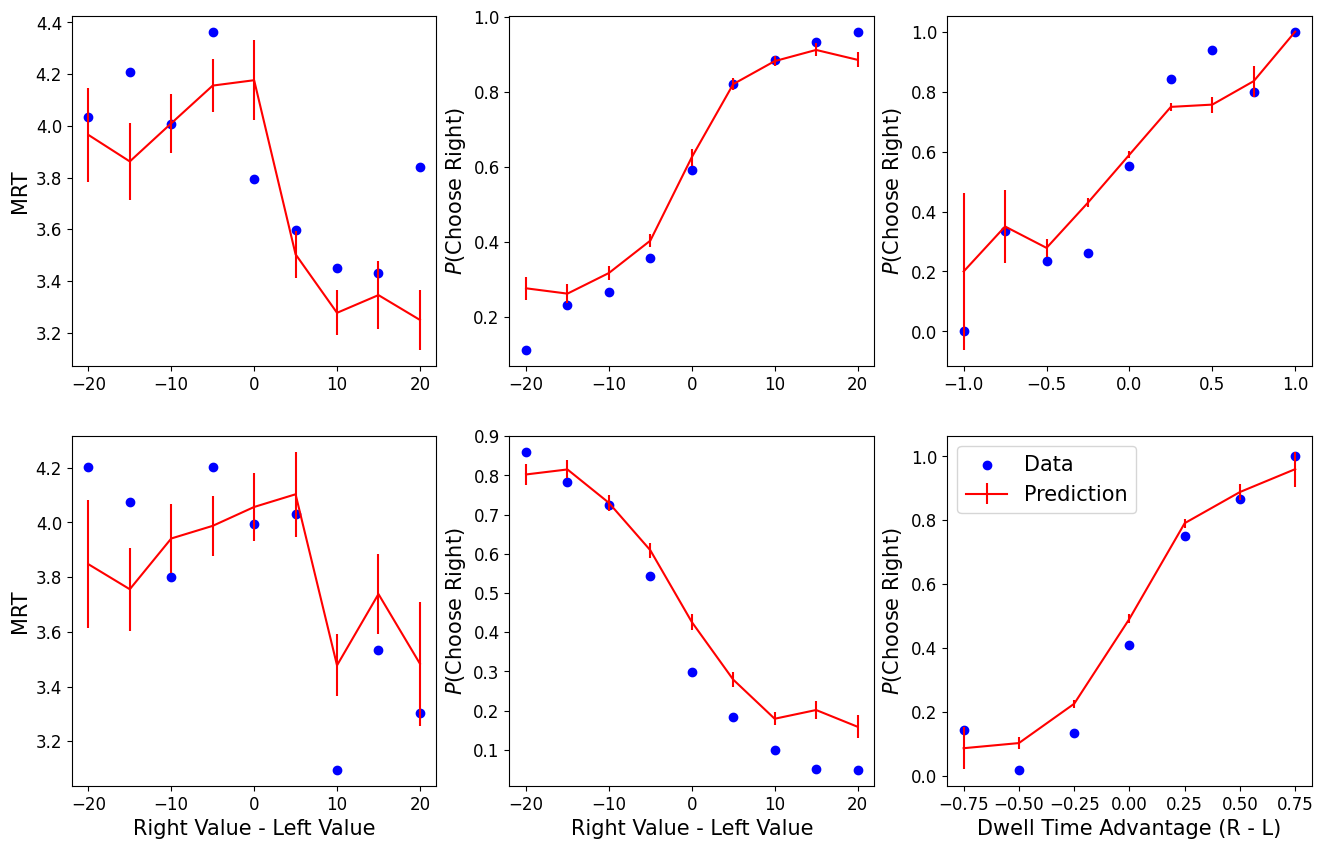

In [13]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.ylabel('MRT');

plt.subplot(232)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(233)
se = pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue');
plt.ylabel(r'$P$(Choose Right)');

###########
plt.subplot(234)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['rt'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['rt'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel('MRT');

plt.subplot(235)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['value_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='value_diff')['ch'].mean(),
             yerr=h, c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['Right Value - Left Value'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Right Value - Left Value')['choice'].mean(), c='blue');
plt.xlabel('Right Value - Left Value');
plt.ylabel(r'$P$(Choose Right)');

plt.subplot(236)
se = pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].sem()
h = se * scipy.stats.t.ppf(1.95 / 2., pred_bhv[pred_bhv['goal']==-1].shape[0])
plt.errorbar(x=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['gaze_diff'].mean(), 
             y=pred_bhv[pred_bhv['goal']==-1].groupby(by='gaze_diff')['ch'].mean(),
             yerr=h, label='Prediction', c='red');
plt.scatter(x=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['Dwell Time Advantage (R - L)'].mean(), 
            y=ts_df[ts_df['goal']==-1].groupby(by='Dwell Time Advantage (R - L)')['choice'].mean(), c='blue', label='Data');
plt.xlabel('Dwell Time Advantage (R - L)');
plt.ylabel(r'$P$(Choose Right)');
plt.legend();

plt.savefig('_plots/sp2020_perceptual_splitted_postpred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');

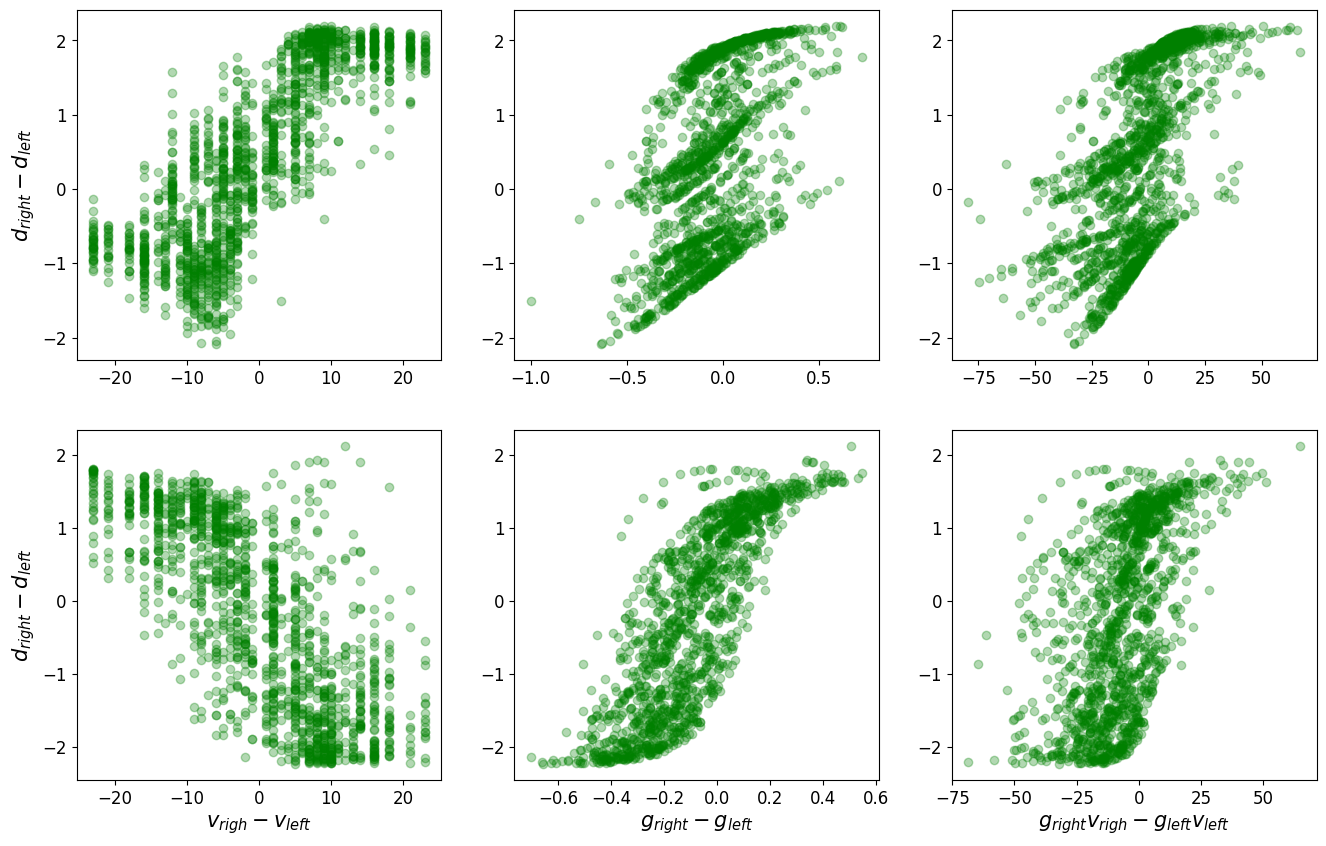

In [14]:
plt.figure(figsize=(16, 10))
plt.subplot(231)
plt.scatter(X_test[X_test[:, -1]==1, 1] - X_test[X_test[:, -1]==1, 0], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(232)
plt.scatter(X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');


plt.subplot(233)
plt.scatter(X_test[X_test[:, -1]==1, 1]*X_test[X_test[:, -1]==1, 3] - X_test[X_test[:, -1]==1, 0]*X_test[X_test[:, -1]==1, 2], 
            pred_v[X_test[:, -1]==1, 1] - pred_v[X_test[:, -1]==1, 0], 
            alpha=0.3, c='green');

#####################
plt.subplot(234)
plt.scatter(X_test[X_test[:, -1]==-1, 1] - X_test[X_test[:, -1]==-1, 0], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$v_{righ} - v_{left}$ ');
plt.ylabel(r'$d_{right} - d_{left}$');

plt.subplot(235)
plt.scatter(X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} - g_{left}$ ');

plt.subplot(236)
plt.scatter(X_test[X_test[:, -1]==-1, 1]*X_test[X_test[:, -1]==-1, 3] - X_test[X_test[:, -1]==-1, 0]*X_test[X_test[:, -1]==-1, 2], 
            pred_v[X_test[:, -1]==-1, 1] - pred_v[X_test[:, -1]==-1, 0], 
            alpha=0.3, c='green');
plt.xlabel(r'$g_{right} v_{righ} - g_{left} v_{left}$ ');

plt.savefig('_plots/sp2020_perceptual_splitted_prmspred.pdf', 
            dpi=600, 
            transparent=True, 
            bbox_inches='tight');